# Importing Packages

In [1]:
import numpy as np
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import idx2numpy
import cv2
import matplotlib.pyplot as plt
from keras.utils import np_utils

Instructions for updating:
non-resource variables are not supported in the long term


# Importing Data Sets

In [2]:
x_train = 'DATA/MNIST/train-images.idx3-ubyte' 
y_train = 'DATA/MNIST/train-labels.idx1-ubyte'
x_test = 'DATA/MNIST/t10k-images.idx3-ubyte'
y_test = 'DATA/MNIST/t10k-labels.idx1-ubyte'
x_train = idx2numpy.convert_from_file(x_train)
y_train = idx2numpy.convert_from_file(y_train)
x_test = idx2numpy.convert_from_file(x_test)
y_test = idx2numpy.convert_from_file(y_test)

# Printing Shapes of Training and Testing Data Sets

In [3]:
print('x_train shape: ', x_train.shape)
print('y_train shape: ', y_train.shape)
print('x_test shape: ', x_test.shape)
print('y_test shape: ', y_test.shape)

x_train shape:  (60000, 28, 28)
y_train shape:  (60000,)
x_test shape:  (10000, 28, 28)
y_test shape:  (10000,)


# Displaying Training Dataset

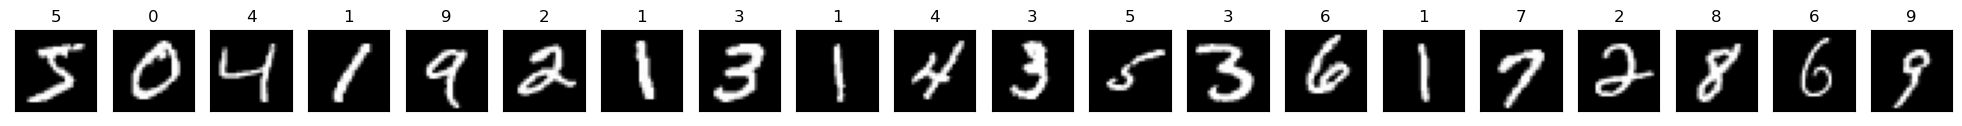

In [4]:
fig = plt.figure(figsize = (25,4))
for i in range(20):
    ax = fig.add_subplot(2,20, i+1, xticks = [], yticks = [])
    ax.imshow(np.squeeze(x_train[i]), cmap = 'gray')
    ax.set_title(str(y_train[i].item()))

# Reshaping Input Datasets for MLP Model

Here we flatten the rows and columns, the shape of the given data set is 28x28=784

In [5]:
x_train = x_train.reshape(60000, 784)
x_test = x_test.reshape(10000, 784)

In [6]:
print('x_train shape: ', x_train.shape)
print('x_test shape: ', x_test.shape)

x_train shape:  (60000, 784)
x_test shape:  (10000, 784)


# Normalising Dataset

By Normalising the Dataset we can reduce the Variance and help the model perform faster and give a better accuracy
Here the dataset consists of images, hence the values will be from 0-255 in grayscale.
We will normalise the dataset to range between 0-1

In [7]:
x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255

# Onehot Encoding for Labels

As explained in the lecture, there are 10 numbers from 0-9, therefore there are 10 classes. In this we will be converting the categorical data variables to be provided to the MLP model which in turn improve predictions as well as classification accuracy of a model.

In [8]:
y_train = np_utils.to_categorical(y_train, 10)
y_test = np_utils.to_categorical(y_test, 10)

# Creating TensorFlow Placeholders

Here we create two placeholders for inputs 'x' and target varibale 'y'. The value 'None' for the first dimension of the shape means that the number of examples in the input data can be any value, and the second dimension 784 in the case of 'x' specifies that each example has 784 features. And the second dimension 10 in 'y' specifies that each example has 10 possible classes (or labels).

These placeholders will later be used to feed actual data into the model during training and evaluation.

In [9]:
x = tf.placeholder(tf.float32, [None, 784])
y = tf.placeholder(tf.float32, [None, 10])

# Model Development

In this step we develop our MLP model. The input x has 784 features which is a flattened image, There are 3 fully connected dense layers with hidden units: 256, 128, and 10. The activation function used in each layer is the rectified linear unit (ReLU), and the output of the final layer 'logits' is the network's prediction.

In [10]:
def model(x):
    w1 = tf.Variable(tf.random_uniform([784, 256])) #weights are randomly assigned
    b1 = tf.Variable(tf.zeros([256])) #Bais Set to zero
    z1 = tf.nn.relu(tf.matmul(x,w1) + b1) #relu activation function used
    w2 = tf.Variable(tf.random_uniform([256, 128]))
    b2 = tf.Variable(tf.zeros([128]))
    z2 = tf.nn.relu(tf.matmul(z1,w2) + b2)
    w3 = tf.Variable(tf.random_uniform([128, 10]))
    b3 = tf.Variable(tf.zeros([10]))
    logits = tf.matmul(z2, w3) + b3       
                     
    return logits
    

In [11]:
logits = model(x) #MLP model being called. the x place holder is passed through it

# Minimising the Loss Function and Update Parameters

The first line calculates the mean of the cross-entropy loss between the predicted logits(model prediction) and the actual labels 'Y' using the softmax activation function. The result is then passed to tf.reduce_mean() to calculate the mean of the cross-entropy loss over the batch size. This gives an overall loss value that represents the average error in the predictions of the model.

In the Second Line, Using Adam optimizer from TensorFlow we want to minimizes the cross-entropy loss. The optimizer adjusts the model's parameters in an attempt to minimize the cross-entropy loss and improve the model's predictions. Further the learning rate is set to 0.01. Which determines the step size that the optimizer takes in the direction of the gradient during training.

In [12]:
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits = logits, labels =y))
min_cost = tf.train.AdamOptimizer(learning_rate=0.01).minimize(cross_entropy)                   

# Main Function

This part of the code is used to define batch_size, epochs and to calculate the Training and Testing Accuracy as well as Loss

In [13]:
# Initializes all the global variables in TensorFlow,
# When this operation is run, all the global variables in the graph will be initialized and set to their default value.
init = tf.global_variables_initializer()  
epochs = 30 #Setting overall Model Epochs to 30
batch_size = 1000 #Defining custom batch size as 1000
iter = len(x_train) // batch_size
train_acc = []
test_acc = []
loss_train_arr = []
loss_test_arr = []

#This code creates a TensorFlow session and runs the init operation(which was defined Earlier) inside it. 
#The with tf.Session() block creates a TensorFlow session, which is used to evaluate operations in the computation graph.

with tf.Session() as sess:
    sess.run(init)
    for epoch in range(epochs):
        avg_loss_train = 0
        avg_loss_test = 0
        start = 0
        end = batch_size
        for i in range(iter):
            
#In the below code feed_dict variable  provides values for the placeholders in the computation graph,  In this case,
#the placeholders x and y are being fed with the slices of the training data x_train[start: end] and y_train[start: end] 
#for training loss and x:x_test, y:y_test for testing loss
            _, loss_train = sess.run([min_cost, cross_entropy], feed_dict = {x:x_train[start: end], y:y_train[start: end]})
            _, loss_test = sess.run([min_cost, cross_entropy], feed_dict = {x:x_test, y:y_test})
            start = start + batch_size
            end = end + batch_size
            avg_loss_train = avg_loss_train + (loss_train/iter) #Calculating average loss during training
            avg_loss_train = np.float32(avg_loss_train)
            avg_loss_test = avg_loss_test + (loss_test/iter) #Calculating average loss during testing
            avg_loss_test = np.float32(avg_loss_test)
        loss_train_arr.append(avg_loss_train)
        loss_test_arr.append(avg_loss_test)
    
    
#This part of the code is to find the accuracy during training and testing for each epoch.
#here the logits tensor has raw, unscaled predictions of a model before any probabilities are assigned
#The tf.nn.softmax function computes the softmax activation for each example in the input tensor,
#producing a probability distribution for each example over all the classes. 
#y_pred now contains the probabilities for each example and each class. 
        y_pred = tf.nn.softmax(logits)
#y_org contains true or false values for the comparison between predicted 'y_pred' and true labels 'y'
        y_org = tf.equal(tf.argmax(y_pred, 1), tf.argmax(y, 1)) 
        accuracy = tf.reduce_mean(tf.cast(y_org, "float"))
        training_acc = accuracy.eval({x:x_train, y:y_train})
        testing_acc = accuracy.eval({x:x_test, y:y_test})
        train_acc.append(training_acc)
        test_acc.append(testing_acc)
        print("Epoch No: "+str(epoch+1)+"\n"+ "Training Accuracy: "+ str(training_acc)+ "\n" + "Testing Accuracy: "+ str(testing_acc)+ "\n")



Epoch No: 1
Training Accuracy: 0.83126664
Testing Accuracy: 0.8444

Epoch No: 2
Training Accuracy: 0.88166666
Testing Accuracy: 0.8966

Epoch No: 3
Training Accuracy: 0.8890667
Testing Accuracy: 0.9069

Epoch No: 4
Training Accuracy: 0.89456666
Testing Accuracy: 0.9153

Epoch No: 5
Training Accuracy: 0.6364833
Testing Accuracy: 0.6465

Epoch No: 6
Training Accuracy: 0.8961
Testing Accuracy: 0.9158

Epoch No: 7
Training Accuracy: 0.91323334
Testing Accuracy: 0.9372

Epoch No: 8
Training Accuracy: 0.90615
Testing Accuracy: 0.9341

Epoch No: 9
Training Accuracy: 0.91145
Testing Accuracy: 0.9322

Epoch No: 10
Training Accuracy: 0.92185
Testing Accuracy: 0.9491

Epoch No: 11
Training Accuracy: 0.9262
Testing Accuracy: 0.9589

Epoch No: 12
Training Accuracy: 0.93125
Testing Accuracy: 0.9689

Epoch No: 13
Training Accuracy: 0.93408334
Testing Accuracy: 0.9728

Epoch No: 14
Training Accuracy: 0.93811667
Testing Accuracy: 0.9776

Epoch No: 15
Training Accuracy: 0.94268334
Testing Accuracy: 0.98

# Plotting

This Section contains the Training and Testing Accuracy VS Epochs and Training and Testing Loss VS Epochs plots

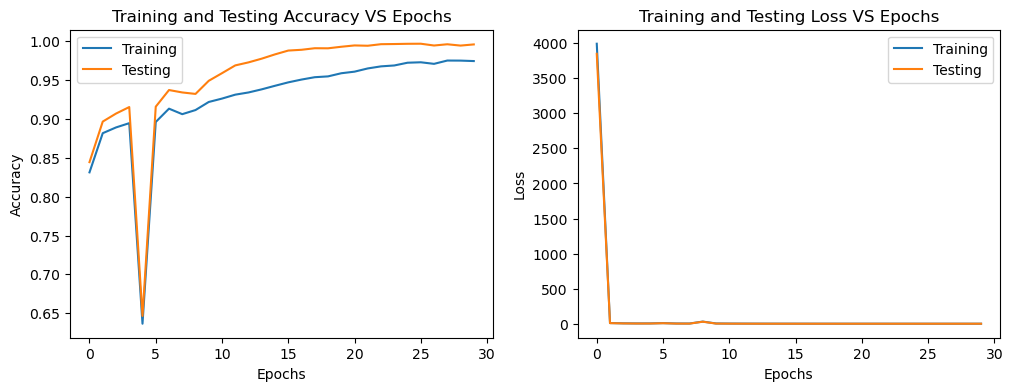

In [14]:
plt.figure(figsize=(12,4))

plt.subplot(121)
x = np.arange(epochs)
plt.plot(x,train_acc, label = 'Training')
plt.plot(x,test_acc, label = 'Testing')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Testing Accuracy VS Epochs')
plt.legend()

plt.subplot(122)
x = np.arange(epochs)
plt.plot(x,loss_train_arr, label = 'Training')
plt.plot(x,loss_test_arr, label = 'Testing')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Testing Loss VS Epochs')
plt.legend()